YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


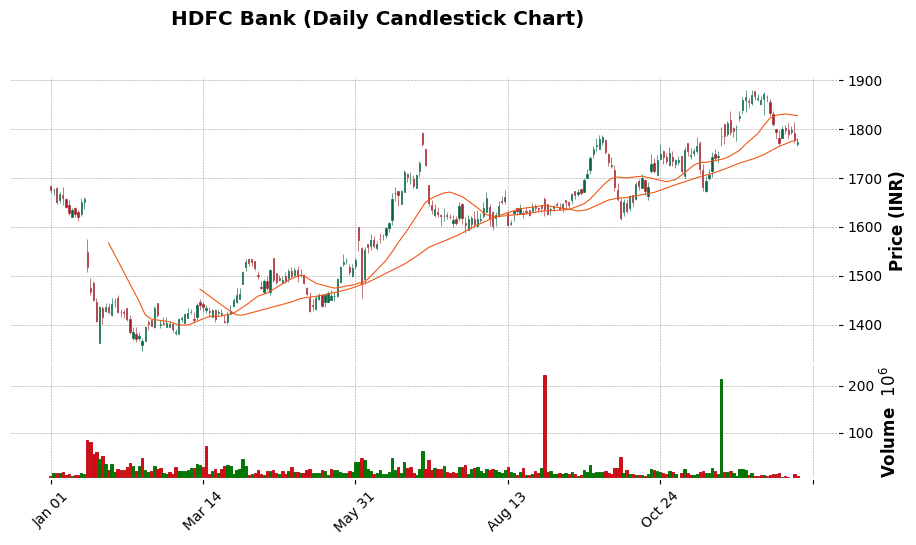

In [ ]:
import pandas as pd
import yfinance as yf
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler

# Load HDFC Bank daily data from NSE
ticker = 'HDFCBANK.NS'
start_date = '2024-01-01'
end_date = '2025-01-01'

data = yf.download(ticker, start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0)

# # Plot candlestick chart using mplfinance
# mpf.plot(data, type='candle', style='charles', title='HDFC Bank (Daily Candlestick Chart)',
#          ylabel='Price (INR)', volume=True, mav=(20, 50), figratio=(16, 8))
data = data.reset_index()

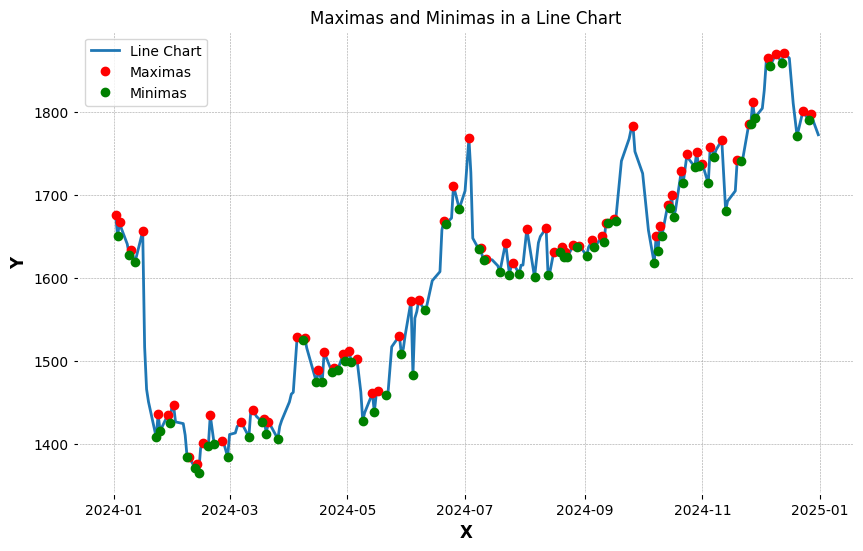

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

x = data['Date']
y = data['Close']

# Find maxima (peaks)
peaks, _ = find_peaks(y)

# Find minima (troughs) by inverting the signal
troughs, _ = find_peaks(-y)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Line Chart')
plt.plot(x[peaks], y[peaks], "ro", label='Maximas')
plt.plot(x[troughs], y[troughs], "go", label='Minimas')
plt.legend()
plt.title('Maximas and Minimas in a Line Chart')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


In [17]:
maxima = data[['Date','Close']][data['Date'].isin(x[peaks])].sort_values('Date',ascending=False).reset_index(drop=True)
maxima['Date_Timestamp'] = maxima['Date'].astype('int64') // 10**9  # In seconds

# Step 2: Standardize Date and Close
scaler = StandardScaler()
standardized = scaler.fit_transform(maxima[['Date_Timestamp', 'Close']])

# Step 3: Add standardized values back to DataFrame
maxima['Date_std'] = standardized[:, 0].astype(float)
maxima['Close_std'] = standardized[:, 1].astype(float)

maxima 

Price,Date,Close,Date_Timestamp,Date_std,Close_std
0,2024-12-27,1798.250000,1735257600,1.643102,1.367334
1,2024-12-23,1801.000000,1734912000,1.605881,1.387991
2,2024-12-13,1871.750000,1734048000,1.512827,1.919442
3,2024-12-09,1870.000000,1733702400,1.475606,1.906296
4,2024-12-05,1865.750000,1733356800,1.438384,1.874372
...,...,...,...,...,...
61,2024-01-24,1436.286865,1706054400,-1.502112,-1.351611
62,2024-01-16,1656.529419,1705363200,-1.576555,0.302777
63,2024-01-10,1633.641846,1704844800,-1.632387,0.130853
64,2024-01-04,1668.071777,1704326400,-1.688219,0.389479


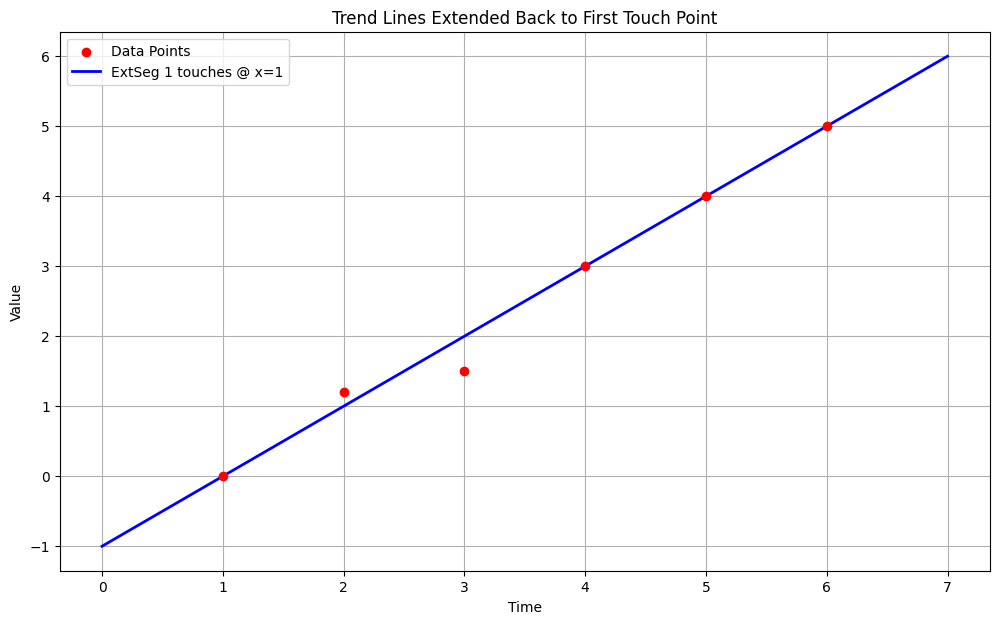

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Hardcoded Data with 20 Data Points ---
# Here x is set to 1, 2, …, 20.
x = np.arange(1, 7)
# x = np.random.randint(0, 20,size=(20))

# Define 20 y-values manually. You can adjust these values to experiment with different trends.
# y = np.array([1, 2.9, 4, 5, 6, 8, 7, 9, 11, 13, 
#               14, 13, 12, 12.5, 13, 15, 16, 17, 19, 20])
y = np.array([0,1.2, 1.5, 3, 4, 5])
z = np.array([1.2, 1.7, 3.3, 4.2, 5.1])

# --- Helper Function for Collinearity Check ---
def is_point_on_line(x_line, y_line, x_pt, y_pt, tol=1e-6):
    """
    Check whether a candidate point (x_pt, y_pt) lies on the line defined by two points 
    given as x_line and y_line (each of length 2), within a tolerance tol.
    """
    x0, x1 = x_line
    y0, y1 = y_line
    if np.isclose(x1, x0):
        # For a vertical line, check if the x coordinate is close.
        return np.abs(x_pt - x0) < tol
    else:
        slope = (y1 - y0) / (x1 - x0)
        predicted = y1 - slope * (x1 - x_pt)
        return np.abs(predicted - y_pt) < tol

# --- Segmentation Function (with Minimum 3 Points Condition) ---
def segment_trend_lines(x, y, tol=1e-6):
    """
    Starting from the latest two points in the data, attempt to extend the trend line backward.
    
    For each candidate segment, the function checks whether an earlier point lies on the extended
    line (within tolerance). Only segments touching three or more consecutive points are retained.
    
    Returns a list of segments. Each segment is a tuple:
       (start_index, end_index, slope, intercept, group_indices)
    where group_indices contains the indices of the consecutive points that form the segment.
    """
    segments = []
    
    def compute_line_params(indices):
        """Compute slope and intercept using the first and last points from indices."""
        x_start, y_start = x[indices[0]], y[indices[0]]
        x_end, y_end = x[indices[-1]], y[indices[-1]]
        if np.isclose(x_end, x_start):
            slope = np.inf
            intercept = None
        else:
            slope = (y_end - y_start) / (x_end - x_start)
            intercept = y_end - slope * x_end
        return slope, intercept

    current_end = len(x) - 1  # start with the latest point
    while current_end > 0:
        # Begin with a candidate segment using the last two points.
        group_indices = [current_end - 1, current_end]
        j = current_end - 2  # index pointer for earlier points
        
        # Extend backwards while the candidate point lies on the current line.
        while j >= 0:
            # Define the line using the earliest and latest point in group_indices.
            x_line = [x[group_indices[0]], x[group_indices[-1]]]
            y_line = [y[group_indices[0]], y[group_indices[-1]]]
            if is_point_on_line(x_line, y_line, x[j], y[j], tol):
                # Add the point at index j to the start of the current group.
                group_indices.insert(0, j)
                j -= 1
            else:
                break
        
        # Only accept this segment if it includes at least 3 points.
        if len(group_indices) >= 3:
            slope, intercept = compute_line_params(group_indices)
            segments.append((group_indices[0], group_indices[-1], slope, intercept, group_indices))
            # Set the new current_end to the earliest point of this accepted segment.
            current_end = group_indices[0]
        else:
            # If only two points form the line, we skip this candidate and move one point back.
            current_end -= 1

    return segments

# --- Get Segments ---
segments = segment_trend_lines(x, y, tol=1e-6)

# 2) for each segment, find the earliest j < start_idx where y[j] lies on the line
extended_segments = []
for start_idx, end_idx, slope, intercept, group in segments:
    ext_start = start_idx
    # walk backward until we hit the first collinear point (if any)
    for j in range(start_idx - 1, -1, -1):
        # predicted y at x[j] on this line
        y_pred = slope * x[j] + intercept
        if np.isclose(y_pred, y[j], atol=1e-6):
            ext_start = j
            break
    extended_segments.append((ext_start, end_idx, slope, intercept, group))

# 3) plot original data + each extended line up to its first touch
plt.figure(figsize=(12, 7))
plt.scatter(x, y, c='red', label='Data Points', zorder=5)
colors = ['blue','green','orange','purple','brown']
for idx, (s_i, e_i, m, b, grp) in enumerate(extended_segments):
    # build a little buffer so it “sticks out” visually
    x0, x1 = x[s_i], x[e_i]
    buf = 0.2 * (x1 - x0)
    xs = np.linspace(x0 - buf, x1 + buf, 200)
    ys = m * xs + b
    plt.plot(xs, ys, color=colors[idx % len(colors)],
             label=f"ExtSeg {idx+1} touches @ x={x[s_i]}", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Trend Lines Extended Back to First Touch Point")
plt.legend()
plt.grid(True)
plt.show()